In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import holidays

# import statsmodels.api as sm
from sklearn.linear_model import QuantileRegressor, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_pinball_loss

# import xgboost as xgb
# from xgboost import XGBRegressor, plot_tree
# import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor

# = = = = = =
# own stuff

os.chdir("C:/Users/ytl_c/OneDrive/Desktop/23_24 WS (Master)/VL - PTSFC/2023_11-PTSFC")
from data_prepro import get_energy_data_today, create_dummy_df, create_features_df

In [3]:
df_energy = get_energy_data_today(to_date="20231201")
print(df_energy.info())
df_energy.tail(5)

C:\Users\ytl_c\OneDrive\Desktop\23_24 WS (Master)\VL - PTSFC\2023_11-PTSFC
0 NA in df
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78168 entries, 2014-12-31 23:00:00+00:00 to 2023-12-01 22:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  78168 non-null  datetime64[ns, CET]
 1   gesamt         78168 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB
None


,timestamp_CET,gesamt
timestamp_UTC,,
2023-12-01 18:00:00+00:00,2023-12-01 19:00:00+01:00,65481.75
2023-12-01 19:00:00+00:00,2023-12-01 20:00:00+01:00,61924.25
2023-12-01 20:00:00+00:00,2023-12-01 21:00:00+01:00,58844.75
2023-12-01 21:00:00+00:00,2023-12-01 22:00:00+01:00,56488.50
2023-12-01 22:00:00+00:00,2023-12-01 23:00:00+01:00,53533.75


In [4]:
import os as os
os.environ["LOKY_MAX_CPU_COUNT"] = "1"  # Replace "4" with the desired number of cores

quantiles_arr = [0.025, 0.25, 0.5, 0.75, 0.975]

### Data Split

In [5]:
df_energy_dummy = create_dummy_df(df_energy, hour_method='seasonal', holiday_method='separate')
df_energy_fturs = create_features_df(df_energy, holiday_method='separate', lags=[24, 7*24])

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# take smaller dataset
start   = '2022-01-01'
end     = '2023-06-01'
df_energy_dummy_small = df_energy_dummy.loc[(df_energy_dummy['timestamp_CET'] > start) & 
                                            (df_energy_dummy['timestamp_CET'] <= end)]
df_energy_fturs_small = df_energy_fturs.loc[(df_energy_fturs['timestamp_CET'] > start) & 
                                            (df_energy_fturs['timestamp_CET'] <= end)]

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =                                       
# time series train test split

# use sklearn TimeSeriesSplit to genrate ...
    # X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy
    # X_train_fturs, X_test_fturs, y_train_fturs, y_test_fturs

X = df_energy_fturs_small.drop(['gesamt', 'timestamp_CET'], axis=1)
y = df_energy_fturs_small['gesamt']

tscv = TimeSeriesSplit(n_splits=2, test_size=100)
for train_index, test_index in tscv.split(X):
    X_train_fturs, X_test_fturs = X.iloc[train_index], X.iloc[test_index]
    y_train_fturs, y_test_fturs = y.iloc[train_index], y.iloc[test_index]

X = df_energy_dummy_small.drop(['gesamt', 'timestamp_CET'], axis=1)
y = df_energy_dummy_small['gesamt']

for train_index, test_index in tscv.split(X):
    X_train_dummy, X_test_dummy = X.iloc[train_index], X.iloc[test_index]
    y_train_dummy, y_test_dummy = y.iloc[train_index], y.iloc[test_index]

# [TODO] cross validation

### Model Train & Fcast

In [6]:
# quant_reg_model = QuantileRegressor(quantile=0.05, alpha=0, solver='highs')
# # alpha is ... Regularization constant that multiplies the L1 penalty term.
# # if alpha is too high ... ie 1 or even 0.5 the coeff are all 0 leading to a constant prediction ...

# quant_reg_fit = quant_reg_model.fit(X_train_dummy, y_train_dummy)

# print(quant_reg_fit.get_params())
# print(quant_reg_fit.intercept_)
# print(quant_reg_fit.coef_)

# # lin_reg_model = LinearRegression()
# # lin_reg_fit = lin_reg_model.fit(X_train_dummy, y_train_dummy)

# # get in sample pred of model
# y_pred_in_sample = quant_reg_fit.predict(X_train_dummy)
# # y_pred_in_sample = lin_reg_fit.predict(X_train_dummy)

# # plot
# plt.figure(figsize=(10, 5))
# plt.plot(y_train_dummy, label='train')
# plt.plot(y_train_dummy.index, y_pred_in_sample, label='in sample fit')
# plt.show()

In [7]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# train quantile models ... regression and gradient boosting

# - - - - - - - - - -
# quantile regression with dummies

# !!! IMPORTANT !!!
# check best params ... alpha = ??? 

print('- '*15)  
print(f'> start training quantile regression models ...')
all_models_quant_reg = {}
for alpha in quantiles_arr:

    print(f'>> alpha = {alpha:.3f} ...')
    quantile_regressor = QuantileRegressor(quantile=alpha, alpha=0, solver='highs')
    all_models_quant_reg[f"q {alpha:.3f}"] = quantile_regressor.fit(X_train_dummy, y_train_dummy)

# - - - - - - - - - -
# gradient boosting with features

# !!! IMPORTANT !!! 
# grid search for best params
# for each quantile ???

common_params = dict(
    learning_rate=0.3,
    max_depth=7,
    min_samples_leaf=5,
    n_estimators=300, 
    subsample=0.9
)

print('- '*15)  
print(f'> start training gradient boosting models ...')
all_models_grad_boost = {}
for alpha in quantiles_arr:

    print(f'>> alpha = {alpha:.3f} ...')
    # Use the QuantileRegressor for faster training on small to medium datasets n < 10_000
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params)

    # Use the HistGradientBoostingRegressor for faster training on large datasets n > 10_000
    # gbr = HistGradientBoostingRegressor(loss='quantile', quantile=alpha, **common_params)

    all_models_grad_boost[f"q {alpha:.3f}"] = gbr.fit(X_train_fturs, y_train_fturs)

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# prediction on test set

print('- '*15)    
print(f'> start prediction ...')

# save fcast in df with columns = quantiles
df_quant_reg_pred = pd.DataFrame(index=y_test_dummy.index)
df_grad_boost_pred = pd.DataFrame(index=y_test_fturs.index)

# Prediction for Quantile Regression
for name, quant_reg_model in sorted(all_models_quant_reg.items()):
    df_quant_reg_pred[name] = quant_reg_model.predict(X_test_dummy)

# Prediction for Gradient Boosting
for name, grad_boost_model in sorted(all_models_grad_boost.items()):
    df_grad_boost_pred[name] = grad_boost_model.predict(X_test_fturs)

def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]

> start training quantile regression models ...
>> alpha = 0.025 ...
>> alpha = 0.250 ...
>> alpha = 0.500 ...
>> alpha = 0.750 ...
>> alpha = 0.975 ...
> start training gradient boosting models ...
>> alpha = 0.025 ...
>> alpha = 0.250 ...
>> alpha = 0.500 ...
>> alpha = 0.750 ...
>> alpha = 0.975 ...
> start evaluation ...


### Plots

In [134]:
# df_ensemble_pred = pd.concat((df_quant_reg_pred, df_grad_boost_pred))

# Custom weights for each DataFrame
weight_quant_reg = 0.05
weight_grad_boost = 0.95

df_ensemble_pred = (df_quant_reg_pred * weight_quant_reg +
                    df_grad_boost_pred * weight_grad_boost)

df_ensemble_pred = df_ensemble_pred.groupby(df_ensemble_pred.index).mean()

def fix_quantile_crossing(df):

    df_out = df.copy()
    
    for index, row in df.iterrows():

        # check if quantiles are in ascending order
        if not all(row.diff().dropna() > 0):
            print(f'> ERROR: Quantiles are not in ascending order for {index}')
            # print(row)
            
            # sort columns 
            df_out.loc[index] = row.sort_values().values
            # print(df_ensemble_pred.loc[index])

    return df_out

# def fix_quantile_crossing(df):

#     # Identify rows where quantiles are not in ascending order
#     mask = (df.diff(axis=1).dropna(axis=1) <= 0).any(axis=1)
#     # Sort the values in ascending order for rows that need correction
#     df.loc[mask] = df.loc[mask].apply(lambda x: sorted(x), axis=1).values[0]

#     return df

df_ensemble_pred = fix_quantile_crossing(df_ensemble_pred)
df_grad_boost_pred = fix_quantile_crossing(df_grad_boost_pred)

In [139]:
# Sample DataFrame
data = {'A': [3, 1, 5], 'B': [8, 4, 6], 'C': [10, 7, 2]}
df = pd.DataFrame(data, index=['X', 'Y', 'Z'])
print(df)

def fix_quantile_crossing(df):

    # Identify rows where quantiles are not in ascending order
    mask = (df.diff(axis=1).dropna(axis=1) <= 0).any(axis=1)
    # Sort the values in ascending order for rows that need correction
    df.loc[mask] = df.loc[mask].apply(lambda x: sorted(x), axis=1).values[0]

    return df

# Display the result
df = fix_quantile_crossing(df)
print(df)

   A  B   C
X  3  8  10
Y  1  4   7
Z  5  6   2
   A  B   C
X  3  8  10
Y  1  4   7
Z  2  5   6


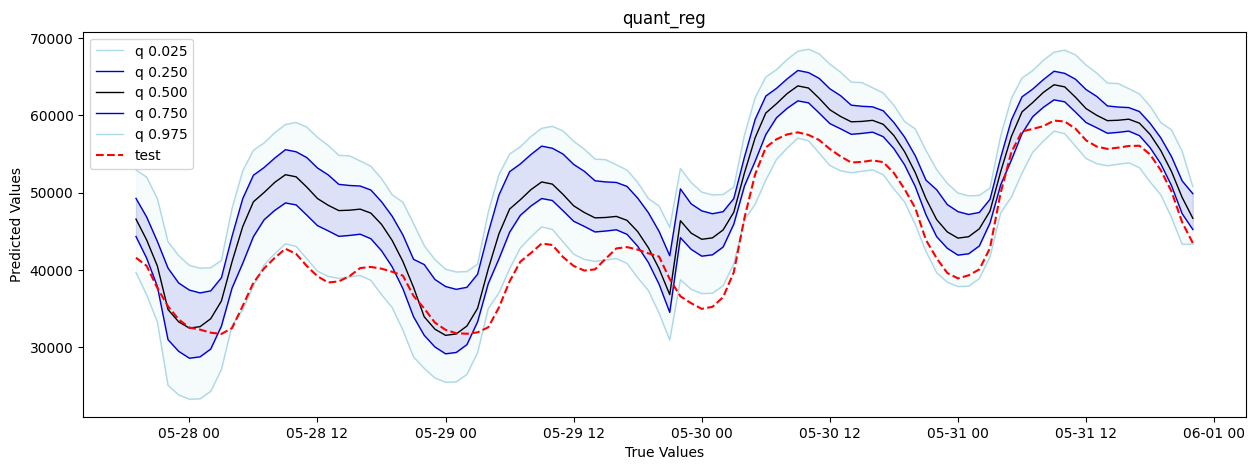

,pbl=0.025,pbl=0.250,pbl=0.500,pbl=0.750,pbl=0.975,MSE
quantile,,,,,,
q 0.025,410.575437,874.686875,1390.366250,1906.045625,2370.157062,13394330
q 0.250,3033.293833,2440.648333,1782.153333,1123.658333,531.012833,16377815
q 0.500,4991.386594,3855.927187,2594.305625,1332.684062,197.224656,35160983
q 0.750,8121.069938,6246.976875,4164.651250,2082.325625,208.232563,79852958
q 0.975,10914.607031,8395.851562,5597.234375,2798.617188,279.861719,136748647


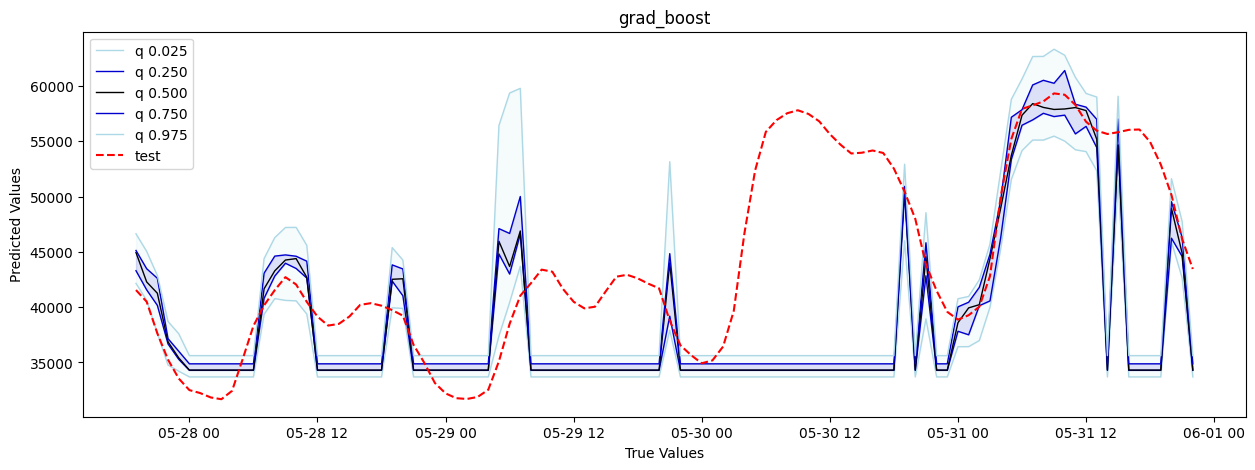

,pbl=0.025,pbl=0.250,pbl=0.500,pbl=0.750,pbl=0.975,MSE
quantile,,,,,,
q 0.025,429.721306,1969.473733,3680.309763,5391.145793,6930.898220,109544748
q 0.250,774.843801,2053.297028,3473.800613,4894.304198,6172.757425,102009524
q 0.500,962.591307,2150.070938,3469.492751,4788.914564,5976.394196,102202743
q 0.750,1356.286539,2358.469045,3472.005163,4585.541281,5587.723787,97898658
q 0.975,2348.784959,3031.817385,3790.742304,4549.667222,5232.699649,104271257


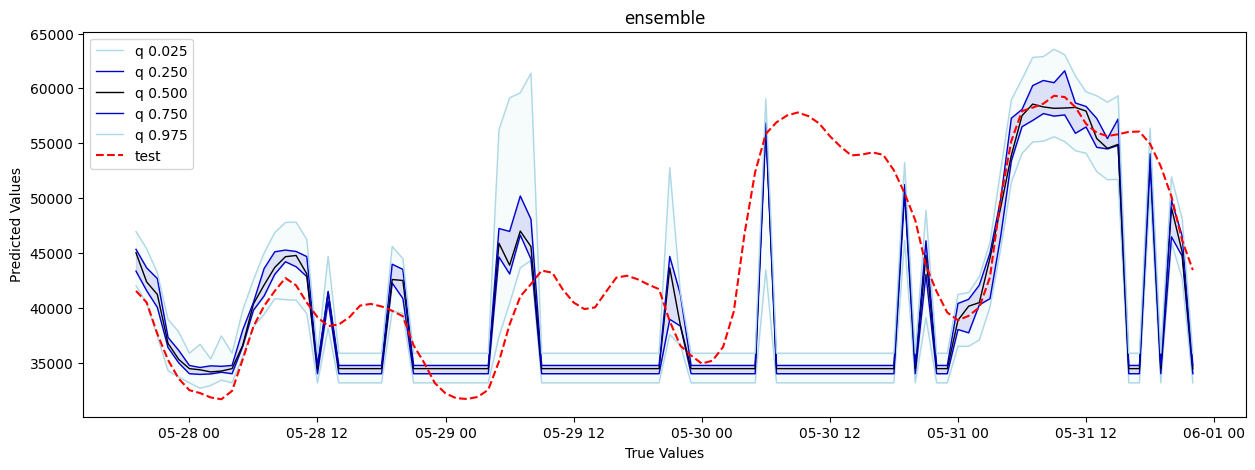

,pbl=0.025,pbl=0.250,pbl=0.500,pbl=0.750,pbl=0.975,MSE
quantile,,,,,,
q 0.025,367.496022,1821.630587,3437.335659,5053.040731,6507.175296,101541262
q 0.250,823.222338,1929.304164,3158.283971,4387.263779,5493.345605,90508354
q 0.500,1103.559731,2050.009934,3101.621270,4153.232607,5099.682810,86598627
q 0.750,1593.393842,2374.824171,3243.080092,4111.336014,4892.766343,86704126
q 0.975,2929.172429,3286.990025,3684.565132,4082.140239,4439.957835,95383388


In [135]:
df_dict = {'quant_reg': df_quant_reg_pred, 
           'grad_boost': df_grad_boost_pred, 
           'ensemble': df_ensemble_pred}

def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]

# iterate over dict
for model, df in df_dict.items(): 

    plt.figure(figsize=(15, 5))
    plt.title(f'{model}')

    model_errors = []

    for quantile in df.columns:

        y_pred = df[quantile]

        metrics = {"quantile": quantile}
        for alpha in quantiles_arr:
            metrics[f"pbl={alpha:.3f}"] = mean_pinball_loss(y_test_fturs, y_pred, alpha=alpha)
        metrics["MSE"] = round(mean_squared_error(y_test_dummy, y_pred))
        model_errors.append(metrics)

        # Save predicted values based on quantile
        if '0.025' in quantile:
            y_pred_025 = y_pred
            col = 'lightblue'
        elif '0.25' in quantile:
            y_pred_25 = y_pred
            col = 'mediumblue'
        elif '0.5' in quantile:
            y_pred_50 = y_pred
            col = 'black'
        elif '0.75' in quantile:
            y_pred_75 = y_pred
            col = 'mediumblue'
        elif '0.975' in quantile:
            y_pred_975 = y_pred
            col = 'lightblue'
        
        # Plot the prediction line
        plt.plot(y_test_dummy.index, y_pred, label=f'{quantile}', lw=1, alpha=1, color=col)

    plt.fill_between(y_test_dummy.index, y_pred_025, y_pred_975, color='lightblue', alpha=0.1)
    plt.fill_between(y_test_dummy.index, y_pred_25, y_pred_75, color='mediumblue', alpha=0.1)

    plt.plot(y_test_dummy.index, y_test_dummy, 'r--', label='test')

    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()

    df_results = pd.DataFrame(model_errors).set_index("quantile")
    # highlight min in column
    # print MSE in scientific notation
    display(df_results.style.highlight_min(axis=0))
